# Circularly polarized patch antenna with parasitic strips

In many applications, such as mobile communications, size, weight, and cost are the primary constraints that drive the design of antennas. In particular, cell phone antennas are required to be economical, low-profile, and easy to manufacture. Patch antennas are attractive devices for these applications, since they can be manufactured directly on printed-circuit boards, which makes their inclusion in cell phones especially convenient. In addition, the shape of a patch antenna can be chosen to imbue it with a variety of different characteristics, e.g., polarization, radiation pattern, and bandwidth.

<img src="img/circularly_polarized_patch_antenna.png" width="400" alt="Rendering of a circularly polarized patch antenna">

In this notebook, we reproduce the results of [Wu et al.](https://ieeexplore.ieee.org/document/6963272) [1]. In [1], the authors propose a circularly polarized antenna with parasitic strips that has a lower profile and an improved circularly polarized bandwidth when compared to existing designs. This notebook also serves to introduce many key components of Tidy3D that are used in antenna simulations: [CoaxialLumpedPort](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.CoaxialLumpedPort.html#tidy3d.plugins.smatrix.CoaxialLumpedPort), [smatrix](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/plugins/smatrix.html) plugin, [FieldProjectionAngleMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldProjectionAngleMonitor.html#tidy3d.FieldProjectionAngleMonitor), and examples of post-processing steps used to compute antenna parameters.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
# Plugin that includes lumped ports
import tidy3d.plugins.smatrix as smatrix
from tidy3d.plugins.dispersion import (
    FastDispersionFitter
)

## Simulation Parameter Setup

We begin by setting the frequency range of interest (2.2 GHz to 3 GHz), which will be used to set up the source and monitors in the simulation. Next, we define geometric parameters from [1] that describe the shape and placement of the various components used in the antenna design. In order to compute $S_{11}$ of the antenna, we will use the [TerminalComponentModeler](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.TerminalComponentModeler.html#tidy3d.plugins.smatrix.TerminalComponentModeler), which requires setting up a port excitation. The antenna in [1] is backed by a ground plane and excited by a feeding pin. In order to emulate a 50 $\Omega$ coaxial cable connected to the feeding pin, we introduce a 1.5 mm radius hole in the ground plane where we will place a `CoaxialLumpedPort`.


We model all conductors from [1] as perfect electric conductors (PECs). In [1], the substrate is modeled with a relative permittivity of 2.55 and frequency-independent loss tangent of 0.002. To ensure causality, in Tidy3D the loss tangent must be modeled using a dispersive material with pole-residue pairs. Fortunately, we can use the [constant_loss_tangent_model](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.dispersion.FastDispersionFitter.html#tidy3d.plugins.dispersion.FastDispersionFitter.constant_loss_tangent_model) to easily generate such a model.

In [2]:
# Frequency range of interest is 2.2 to 3 GHz
freq_start = 2.2e9
freq_stop = 3e9
# Center frequency of 2.6 GHz
freq0 = (freq_start + freq_stop) / 2
fwidth = freq_stop - freq_start
# Frequency sample points for monitors and post-processing
freqs = np.linspace(freq_start, freq_stop, 51)
# Center wavelength
wavelength0 = td.C_0 / freq0
# Longest wavelength
wavelength_start = td.C_0 / freq_start
# Run time of FDTD simulation
run_time = 10/fwidth
# Tidy3D uses microns by default
mm = 1e3

# Parameters from [1]
G = 130 * mm  # Length and width of ground sheet
L = 73 * mm  # Length and width of substrate
L1 = 39 * mm  # Length and width of center patch
a = 21 * mm  # Width of corner cutout of center patch
fx = 15 * mm  # X position of feed pin
gx = 2 * mm  # Horizontal gap distance between center patch and parasitic patches
gy = 8 * mm  # Vertical gap distance between substrate boundary and parasitic patches
Ls = 36 * mm  # Length of parasitic patches
Ws = 15 * mm  # Width of parasitic patches
r1 = 2 * mm  # Ground pin pad size
r2 = 1.7 * mm  # Feed pin pad size
t = 1 * mm  # Substrate thickness
H = 14 * mm  # Distance between ground and substrate
rfeed = 0.65 * mm

# Custom parameters chosen for this simulation, not specified in [1]
# Chosen thickness of metal conductors other than the ground sheet (20 microns)
patch_thickness = 0.02 * mm
ground_thickness = 0.16 * mm
# Using an outer radius of 1.5 mm gives about 50 Ohms
# for the impedance of air filled coax that connects to the feeding pin.
coax_radius = 1.5 * mm

# Total structure height
structure_height = t + H + ground_thickness + patch_thickness
structure_center = 0.5 * (t + patch_thickness - H - ground_thickness)

# PML buffer size added around structures
PML_buffer = wavelength_start/2
# Simulation domain definition with sufficient padding around the structure for PMLs
sim_size = (G + 2 * PML_buffer, G + 2 * PML_buffer, structure_height + 2 * PML_buffer)
sim_center = [0, 0, structure_center]

# Define media in the simulation
epsr_sub = 2.55
air = td.Medium()
metal = td.PECMedium()
# Use FastDispersionFitter to create a material with an approximately correct loss tangent for the frequency range.
substrate_med = FastDispersionFitter.constant_loss_tangent_model(
    epsr_sub, 0.002, (freq_start, freq_stop)
)

Output()

## Create Structures

Next, we use the defined parameters to create all of the structures in the Tidy3D simulation and plot the created structure.

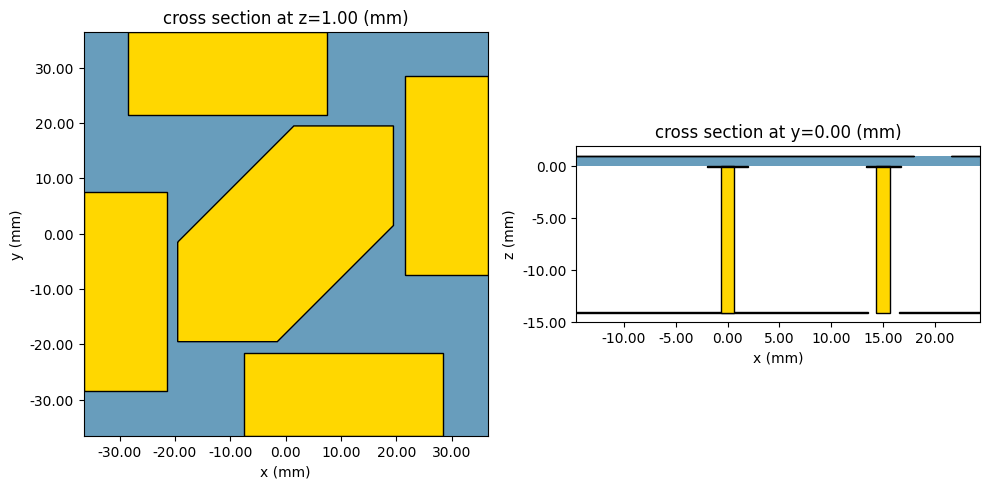

In [3]:
# Dielectric substrate that extends from the shorting and feeding pins to the patches
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, t / 2],
        size=[L, L, t],
    ),
    medium=substrate_med,
)
# A ground plane is connected to the bottom of the pins, where a small air gap is introduced for exciting the
# feeding pin
ground_box = td.Box(
    center=[0, 0, -H - ground_thickness / 2], size=[G, G, ground_thickness]
)
# A cylindrical hole is created in the ground plane to allow for the coaxial cable connection at the feeding pin.
feed_gap = td.Cylinder(
    center=(fx, 0, -H - ground_thickness / 2),
    radius=coax_radius,
    length=ground_thickness,
    axis=2,
)
# The air gap is removed from the ground box
ground_with_holes = td.ClipOperation(
    operation="difference", geometry_a=ground_box, geometry_b=feed_gap
)
# The final ground plane structure is created
ground = td.Structure(
    geometry=ground_with_holes,
    medium=metal,
)
# Define the vertices that outline the shape of the central patch.
main_vertices = np.array(
    [
        (-L1 / 2, -L1 / 2),
        (L1 / 2 - a, -L1 / 2),
        (L1 / 2, -L1 / 2 + a),
        (L1 / 2, L1 / 2),
        (-L1 / 2 + a, L1 / 2),
        (-L1 / 2, L1 / 2 - a),
    ]
)
# Using the vertices, a polyslab structure is created with the previously defined patch_thickness.
main_patch = td.Structure(
    geometry=td.PolySlab(
        vertices=main_vertices.tolist(),
        slab_bounds=(t, t + patch_thickness),
        axis=2,
    ),
    medium=metal,
)
# The remaining parasitic strips are sequentially-rotated rectangles around the central patch.
patch_L = td.Box(
    center=(-L / 2 + Ws / 2, -L / 2 + gy + Ls / 2, t + patch_thickness / 2),
    size=(Ws, Ls, patch_thickness),
)
patch_R = td.Box(
    center=(L / 2 - Ws / 2, L / 2 - gy - Ls / 2, t + patch_thickness / 2),
    size=(Ws, Ls, patch_thickness),
)
patch_B = td.Box(
    center=(L / 2 - Ls / 2 - gy, -L / 2 + Ws / 2, t + patch_thickness / 2),
    size=(Ls, Ws, patch_thickness),
)
patch_T = td.Box(
    center=(-L / 2 + Ls / 2 + gy, L / 2 - Ws / 2, t + patch_thickness / 2),
    size=(Ls, Ws, patch_thickness),
)
# Conductive pads for the feeding and shorting pins, placed at the bottom of the substrate.
feed_disc = td.Cylinder(
    center=(fx, 0, -patch_thickness / 2), radius=r2, length=patch_thickness, axis=2
)
shorted_disc = td.Cylinder(
    center=(0, 0, -patch_thickness / 2), radius=r1, length=patch_thickness, axis=2
)
# All patch structures are collected into a list and assigned the same material
patch_geoms = [patch_L, patch_R, patch_B, patch_T, feed_disc, shorted_disc]
patch_structures = [td.Structure(geometry=patch, medium=metal) for patch in patch_geoms]

# Next, the shorting and feeding pins are added to the simulation as cylinders.
short_pin = td.Structure(
    geometry=td.Cylinder(
        center=(0, 0, -H / 2 - ground_thickness / 2),
        radius=rfeed,
        length=H + ground_thickness,
        axis=2,
    ),
    medium=metal,
)
feed_pin = td.Structure(
    geometry=td.Cylinder(
        center=(fx, 0, -H / 2 - ground_thickness / 2),
        radius=rfeed,
        length=H + ground_thickness,
        axis=2,
    ),
    medium=metal,
)
# Create a list of all structures in the simulation.
structures_list = [
    substrate,
    ground,
    feed_pin,
    short_pin,
    main_patch,
] + patch_structures
# Setting up the scene for visualization, with all structures included
# and units set to millimeters for the plot.
scene = td.Scene(structures=structures_list, plot_length_units="mm")
fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
sub_ax = axs[0]
scene.plot(z=t, ax=sub_ax)
sub_ax.set_xlim(-L / 2, L / 2)
sub_ax.set_ylim(-L / 2, L / 2)
sub_ax = axs[1]
scene.plot(y=0, ax=sub_ax)
sub_ax.set_xlim(-L / 5, L / 3)
sub_ax.set_ylim(-H - t, 2 * t)
plt.show()

## Mesh Overrides and Snapping Points

In this antenna design, there are many subwavelength features that may not be captured accurately using the default grid generated by Tidy3D, even when using the [PECConformal](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PECConformal.html#tidy3d.PECConformal) subpixel feature. For instance, both the metal patch thickness and the gap between the central patch and parasitic strips are subwavelength. In addition, the radius of the shorting and feeding pins are also relatively small. To enhance the accuracy of this simulation we will use two components: [MeshOverrideStructures](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.MeshOverrideStructure.html#tidy3d.MeshOverrideStructure) and `snapping_points`.

The `MeshOverrideStructure`s are used to refine the grid in the *xy*-plane around the central patch and parasitic strips, along the *z* axis near the thin metal structures, and near the locations of the shorting and feeding pins. For the area containing the patch and parasitic strips, we use a grid spacing small enough to place four grid cells in the gap between the central patch and neighboring parasitic strips. We use a grid cell size at the substrate interfaces that is double the thickness of printed metallic components. Using a smaller cell size would lead to a more accurate result, but since the FDTD time-step size is linked to the smallest grid cell size through the Courant condition, making the cell size smaller can significantly increase the duration of the simulation. We use `MeshOverrideStructure`s to ensure that there will be about four grid cells in the gap between the feeding pin and ground plane, where the excitation will be placed. Finally, another similar `MeshOverrideStructure` is added near the shorting pin to resolve the cylinder's surface accurately.

In [4]:
# Define key vertical locations within the simulation domain.
top_substrate = t
bottom_substrate = 0
middle_ground = -H - ground_thickness/2
port_location = -H - ground_thickness # Port is located at the bottom of the ground.
# Calculate the diameter of the coaxial port based on the radius.
port_diameter= 2 * coax_radius

# Set the size of grid cells to be used for the portion of the structure containing all patches.
# Choose the cell size in the xy-plane to ensure there are 4 cells across the gap between the main patch and parasitic strips.
dl_plane = gx/4
# Vertical cell size around printed components
dz_metal = 2*patch_thickness

mesh_overrides = []
# Main structure refinement along x and y
# Two MeshOverrideStructures are used to target the interfaces between the substrate and air.
# An additional MeshOverrideStructure is used to further discretize the ground plane.
mesh_overrides.extend(
    [
        td.MeshOverrideStructure(
            geometry=td.Box(
                center=[0, 0, top_substrate + dz_metal / 2],
                size=[L, L, dz_metal],
            ),
            dl=[dl_plane, dl_plane, dz_metal],
        ),
        td.MeshOverrideStructure(
            geometry=td.Box(
                center=[0, 0, bottom_substrate - dz_metal / 2],
                size=[L, L, dz_metal],
            ),
            dl=[dl_plane, dl_plane, dz_metal],
        ),
        td.MeshOverrideStructure(
            geometry=td.Box(
                center=[0, 0, middle_ground],
                size=[L, L, ground_thickness],
            ),
            dl=[dl_plane, dl_plane, ground_thickness/2],
        )
    ]
)
# Provide a larger cell size (dl value) for regions or dimensions that do not require fine resolution.
dl_background = 10 * mm
# Set the cell size at the port to fit approximately `port_cells` between the feed pin and ground
port_cells = 4
dl_pins = (coax_radius - rfeed) / port_cells
# Add MeshOverrideStructures around both pins, which will capture the curved geometry of the cylinders more accurately.
# These MeshOverrideStructures also improve the accuracy of the fields in the air gap, where the port excitation will be placed.
mesh_overrides.extend(
    [
        td.MeshOverrideStructure(
            geometry=td.Box(
                center=[fx, 0, middle_ground],
                size=[port_diameter, port_diameter, ground_thickness],
            ),
            dl=[dl_pins, dl_pins, dl_background],
        ),
        td.MeshOverrideStructure(
            geometry=td.Box(
                center=[0, 0, middle_ground],
                size=[port_diameter, port_diameter, ground_thickness],
            ),
            dl=[dl_pins, dl_pins, dl_background],
        ),
    ]
)

In the FDTD method, it is advantageous to align the grid cell boundaries with the geometric vertices of metallic structures to minimize numerical errors and improve simulation accuracy. In Tidy3D, this can be accomplished by adding `snapping_points` to the `GridSpec`. In this simulation, we add the corners of the patch and parasitic strips in the *xy*-plane as snapping points to ensure that their precise positions are accurately represented in the simulation grid.

In [5]:
# Create snapping points at the corners of the central patch and at the corners (bounds) of each parasitic strip.
# The precise vertical position of the snapping points is less critical since the important features to capture are in the xy-plane.
# Here, we select the top interface of the substrate as a reference z-position.
center_patch_points = [(v[0], v[1], top_substrate) for v in main_vertices]
parasitic_bounds = [(bound[0], bound[1], top_substrate) for patch in [patch_L, patch_R, patch_B, patch_T] for bound in patch.bounds ]
snapping_points = center_patch_points + parasitic_bounds

Now, we plot the created geometry along with the FDTD grid to see how the `MeshOverrideStructure`s and `snapping_points` have affected the grid. In the first figure, the effect of the `MeshOverrideStructure`s around the shorting and feeding pins can be seen, as well as the location of the `snapping_points`, which are the solid black dots. The figure on the right shows a closeup of the gap region between the center patch and a parasitic strip, where there are four grid cells as desired. The subsequent plot shows the refined grid near the port location.

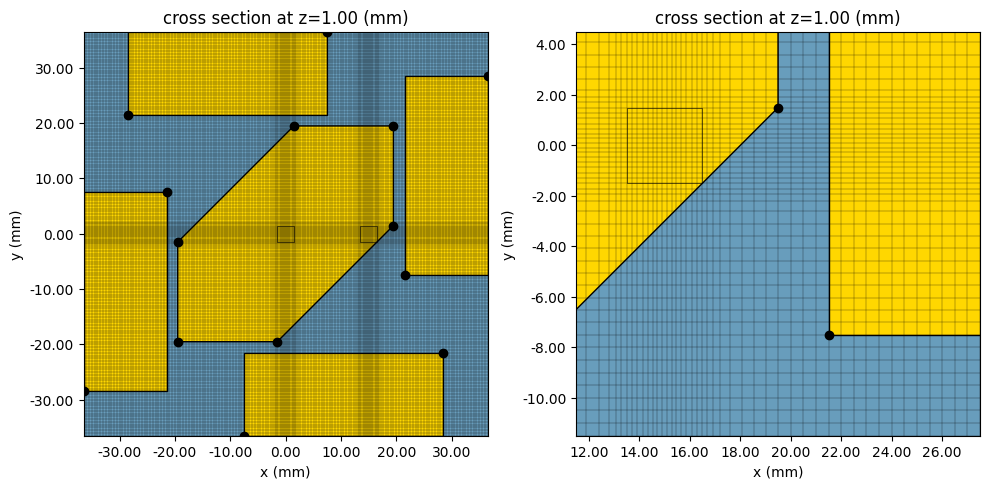

Number of cells along each axis: [246, 233, 113]
Smallest cell size along each axis: (185.71, 185.71, 40.00)


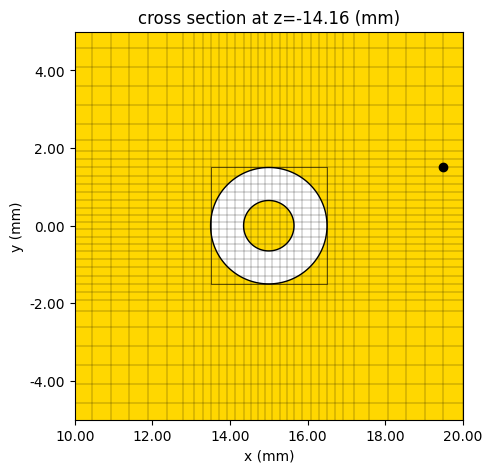

In [6]:

# Create simulation object, so that we can view the created grid superimposed with simulation structures.
sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=20,
        wavelength=td.C_0 / freq_stop,
        override_structures=mesh_overrides,
        snapping_points=snapping_points,
        dl_min=patch_thickness
    ),
    structures=structures_list,
    run_time=run_time,
    plot_length_units="mm"
)

# Create two plots: one showing the overall grid and simulation setup, and another zoomed in near the gap and feed pin location.
fig, axs = plt.subplots(1, 2, figsize=(10, 10), tight_layout=True)
sub_ax = axs[0]
sim.plot(z=t, ax=sub_ax, monitor_alpha=0)
sim.plot_grid(z=t, ax=sub_ax)
sub_ax.set_xlim(-L/2, L/2)
sub_ax.set_ylim(-L/2, L/2)
sub_ax = axs[1]
sim.plot(z=t, ax=sub_ax, monitor_alpha=0)
sim.plot_grid(z=t, ax=sub_ax)
sub_ax.set_xlim(L1 / 2 - 4 * gx, L1 / 2 + 4 * gx)
sub_ax.set_ylim(L / 2 - gy - Ls - 2 * gx, L / 2 - gy - Ls + 6 * gx)
plt.show()

# Display information about the simulation grid, including the number of cells along each axis and the smallest cell size,
# which are important for simulation accuracy.
print(f"Number of cells along each axis: {sim.grid.num_cells}")
print(f"Smallest cell size along each axis: ({np.min(sim.grid.sizes.x):.2f}, {np.min(sim.grid.sizes.y):.2f}, {np.min(sim.grid.sizes.z):.2f})")

# Create a detailed plot at the port location to verify the mesh refinement in this critical region.
fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)
sim.plot(z=port_location, ax=ax)
sim.plot_grid(z=port_location, ax=ax)
ax.set_xlim(fx - 5 * mm, fx + 5 * mm)
ax.set_ylim(-5 * mm, 5 * mm)
plt.show()

## Simulation Monitors

In this notebook, we wish to compute a variety of antenna parameters. We will first create plots of the normalized radiation pattern at 2.6 GHz for right-handed and left-handed circular polarizations. We will also reproduce a few plots from [1] that are functions of frequency, i.e., the axial ratio and the antenna gain along the *z* axis. In order to create these plots efficiently, we use one `FieldProjectionAngleMonitor` that records the far-field pattern over a range of directions at a fixed frequency. We use a separate `FieldProjectionAngleMonitor` to capture the field over a range of frequencies at a specific observation point, denoted by spherical coordinates $(\theta=0, \phi=0)$.

In [7]:
# Place the far field monitors just inside simulation boundaries
farfield_size = (sim_size[0] * 0.9, sim_size[1] * 0.9, sim_size[2] * 0.9)
# Radial distance away from the origin at which to project fields.
r_proj = 50 * wavelength0
# Theta and Phi angles at which to observe fields
theta_proj = np.linspace(0, 2 * np.pi, 201)
phi_proj = np.linspace(0, np.pi/2, 2)

# First, create a FieldProjectionAngleMonitor that will be used to plot the radiation pattern in the xz and yz planes
mon_rad_spatial = td.FieldProjectionAngleMonitor(
    center=sim_center,
    size=farfield_size,
    # the size and center of any far field monitor should indicate where the *near* fields are recorded
    freqs=[freq0],
    name="rad_spatial",
    phi=list(phi_proj),
    theta=list(theta_proj),
    proj_distance=r_proj,
    far_field_approx=True, # Compute the radiated fields in the far field.
)

# Next, create a FieldProjectionAngleMonitor that will be used to compute radiated fields normal to the antenna vs the frequency.
mon_rad_freqency = td.FieldProjectionAngleMonitor(
    center=sim_center,
    size=farfield_size,
    freqs=freqs, # Record radiated fields for different frequencies.
    name="rad_frequency",
    phi=[0], # Record radiated fields normal to the antenna
    theta=[0],
    proj_distance=r_proj,
    far_field_approx=True, # Compute the radiated fields in the far field.
)

# Finally, add a FluxMonitor to calculate the total radiated power.
mon_flux = td.FluxMonitor(
    center=sim_center,
    size=farfield_size,
    name="power",
    freqs=freqs
)
sim = sim.updated_copy(monitors=[mon_flux, mon_rad_spatial, mon_rad_freqency])

## Set up the `TerminalComponentModeler`

The last step before launching the simulation is to set up the `TerminalComponentModeler`, which will simplify the calculation of $S_{11}$. As previously mentioned, we use a `CoaxialLumpedPort` with a reference impedance of $50 \Omega$ as the source. The `CoaxialLumpedPort` will model a radially directed uniform current source and an annular resistive load between the feed pin and ground plane. Scattering parameters calculated with this definition of the `CoaxialLumpedPort` should match experimental results where a coaxial cable is used with characteristic impedance of $50 \Omega$.

In [8]:
# Use a CoaxialLumpedPort to excite the feed pin. The CoaxialLumpedPort models a radially symmetric current
# flowing from the feed pin to the ground plane through a resistive element.
coax_center = [fx, 0, port_location]
coax_port = smatrix.CoaxialLumpedPort(
    center=coax_center,
    outer_diameter=port_diameter, # Defines the boundary for the outer conductor, which in this case is the ground plane.
    inner_diameter=2 * rfeed, # Defines the boundary for the inner conductor, corresponding to the feed pin diameter.
    normal_axis=2,
    direction="+", # Indicates that the current will flow in the positive direction along the feed pin.
    name="coax_port",
    num_grid_cells=None,  # The port grid refinement is handled manually with MeshOverrideStructures, hence 'None'.
)
modeler = smatrix.TerminalComponentModeler(
    simulation=sim,
    ports=[coax_port],
    freqs=freqs,
    remove_dc_component=True,
    verbose=True,
)

Next, we run the simulation that computes the scattering matrix. After the simulation is complete, we retrieve the `BatchData` and `SimulationData`, which contain the results from the far-field monitors.

In [9]:
# Run the TerminalComponentModeler and populate the scattering matrix of this single CoaxialLumpedPort network.
s_matrix = modeler.run()
# Load the BatchData used to compute the scattering parameters
batch_data = modeler.batch.load()
# Retrieve SimulationData from the BatchData
sim_data = batch_data["smatrix_coax_port"]

Output()

09:19:32 EDT Started working on Batch containing 1 tasks.

09:19:37 EDT Maximum FlexCredit cost: 0.364 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

09:21:59 EDT Batch complete.

Output()

## Postprocessing
### Polar plots of normalized radiation patterns
We will use the simulation results to reproduce Fig. 10 (b) from [1]. First, we convert the recorded electric fields into radiation densities decomposed into right-handed circular polarization (RHCP) and left-handed circular polarization (LHCP) components. Then, we normalize by the peak total radiation density.

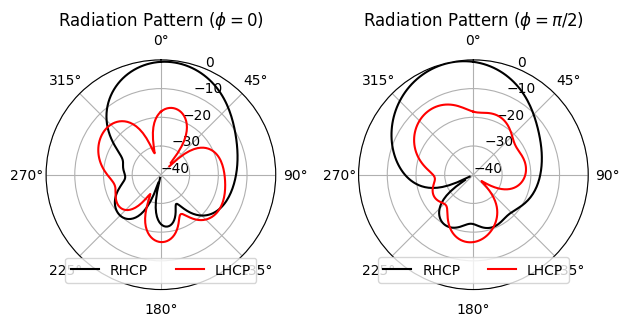

In [10]:
# Retrieve the field data from the "rad_spatial" monitor
rad_pattern = sim_data["rad_spatial"]
# Right-handed circular polarization component
E_RH = (rad_pattern.Etheta - 1j * rad_pattern.Ephi) / (np.sqrt(2))
# Left-handed circular polarization component
E_LH = (rad_pattern.Etheta + 1j * rad_pattern.Ephi) / (np.sqrt(2))
# Average power density in the right and left-handed polarizations
W_RH = 0.5 * np.real(E_RH * np.conj(E_RH) / td.ETA_0)
W_LH = 0.5 * np.real(E_LH * np.conj(E_LH) / td.ETA_0)
# Normalize radiation pattern by the peak radiation density
normalize = np.max(
    abs(rad_pattern.Etheta.values) ** 2 + abs(rad_pattern.Ephi.values) ** 2
) / (2 * td.ETA_0)
# Select and normalize each field for plotting
P = W_RH.sel(phi=0, method="nearest").values
P = np.squeeze(P)
Urad_RH_Phi_0 = P / normalize
P = W_RH.sel(phi=np.pi / 2, method="nearest").values
P = np.squeeze(P)
Urad_RH_Phi_90 = P / normalize

P = W_LH.sel(phi=0, method="nearest").values
P = np.squeeze(P)
Urad_LH_Phi_0 = P / normalize
P = W_LH.sel(phi=np.pi / 2, method="nearest").values
P = np.squeeze(P)
Urad_LH_Phi_90 = P / normalize

# Plot the normalized radiation pattern similar to [1].
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "polar"})
sub_ax = ax[0]
sub_ax.set_theta_direction(-1)
sub_ax.set_theta_offset(np.pi / 2.0)
sub_ax.plot(theta_proj, 10 * np.log10(Urad_RH_Phi_0), "-k", label="RHCP")
sub_ax.plot(theta_proj, 10 * np.log10(Urad_LH_Phi_0), "-r", label="LHCP")
sub_ax.set_rlim(-40, 0)
sub_ax.set_rticks([-40, -30, -20, -10, 0])
sub_ax.set_title(r"Radiation Pattern ($\phi = 0$)")
sub_ax.legend(loc="lower center", ncols=2)

sub_ax = ax[1]
sub_ax.set_theta_direction(-1)
sub_ax.set_theta_offset(np.pi / 2.0)
sub_ax.plot(theta_proj, 10 * np.log10(Urad_RH_Phi_90), "-k", label="RHCP")
sub_ax.plot(theta_proj, 10 * np.log10(Urad_LH_Phi_90), "-r", label="LHCP")
sub_ax.set_rlim(-40, 0)
sub_ax.set_rticks([-40, -30, -20, -10, 0])
sub_ax.set_title(r"Radiation Pattern ($\phi = \pi/2$)")
sub_ax.legend(loc="lower center", ncols=2)
fig.tight_layout()
plt.show()

### Plot of $S_{11}$
Next, we reproduce Fig. 9 (a) from [1] using the scattering parameter computed by the `TerminalComponentModeler`.

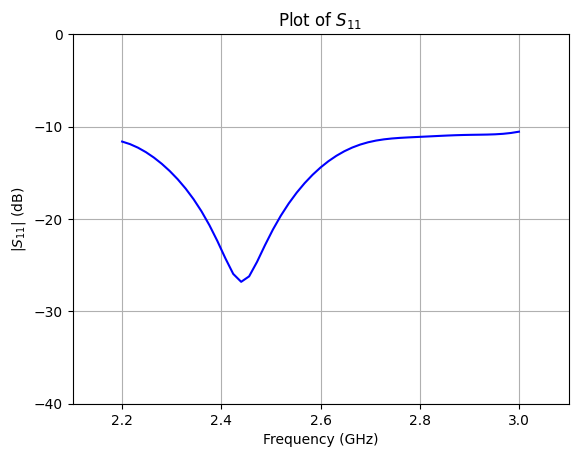

In [11]:
# Plot the reflection coefficient using the scattering parameter computed by the TerminalComponentModeler
freq = s_matrix.f / 1e9
y_tidy3D = 20 * np.log10(
    np.abs(s_matrix.isel(port_out=0, port_in=0).values.flatten())
)
plt.plot(freq, y_tidy3D, "-b")
plt.xlabel("Frequency (GHz)")
plt.ylabel(r"$|S_{11}|$ (dB)")
plt.title(r"Plot of $S_{11}$")
# Make the plot identical to [1].
plt.xlim(2.1, 3.1)
plt.ylim(-40, 0)
plt.yticks([-40, -30, -20, -10, 0])
plt.grid(True)
plt.show()

### Compute and plot the axial ratio
Next, we use the simulation results to reproduce Fig. 9 (a) from [1]. The axial ratio is computed using (2-66) and (2-67) in [2].

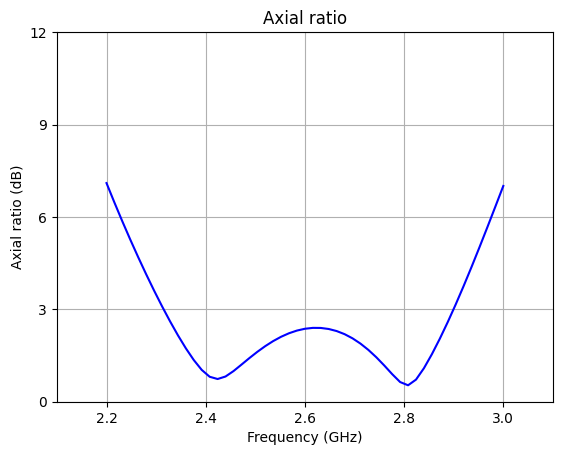

In [12]:
# Retrieve the field data from the "rad_frequency" monitor
rad_field = sim_data["rad_frequency"]
#Compute the axial ratio at the position normal to the antenna
cartesian_fields = rad_field.fields_cartesian
Ex = cartesian_fields.Ex.sel(phi=0, theta=0, method="nearest").values.flatten()
Ey = cartesian_fields.Ey.sel(phi=0, theta=0, method="nearest").values.flatten()
deltaPhi = np.angle(Ey) - np.angle(Ex)
Ex0 = np.abs(Ex)
Ey0 = np.abs(Ey)
# Use equations given in [2]
OA = np.sqrt(0.5*(Ex0**2+Ey0**2 + np.sqrt(Ex0**4 + Ey0**4 + 2*Ex0**2*Ey0**2*np.cos(2*deltaPhi))))
OB = np.sqrt(0.5*(Ex0**2+Ey0**2 - np.sqrt(Ex0**4 + Ey0**4 + 2*Ex0**2*Ey0**2*np.cos(2*deltaPhi))))
AR = OA/OB

freq = cartesian_fields.f.values / 1e9
y_tidy3D = 20 * np.log10(np.abs(AR))
plt.plot(freq,y_tidy3D ,'-b')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Axial ratio (dB)')
plt.title('Axial ratio')
# Make the plot identical to [1].
plt.xlim(2.1, 3.1)
plt.ylim(0, 12)
plt.yticks([0, 3, 6, 9, 12])
plt.grid(True)
plt.show()

### Compute and plot the antenna gain for RHCP
To conclude this notebook, we will compute and plot the antenna gain specifically for the RHCP component. We begin by calculating the directivity for the RHCP component using the total radiated power from the far-field radiation pattern. Next, we employ the `compute_power_delivered_by_port` helper function provided by the `TerminalComponentModeler` to determine the power delivered to the antenna via the port. This value allows us to calculate the radiation efficiency, which indicates how effectively the antenna converts the power delivered by the port into radiated power.

With the directivity and radiation efficiency determined, we can then compute the antenna gain. The resulting plot will replicate Fig. 9(b) from [1].

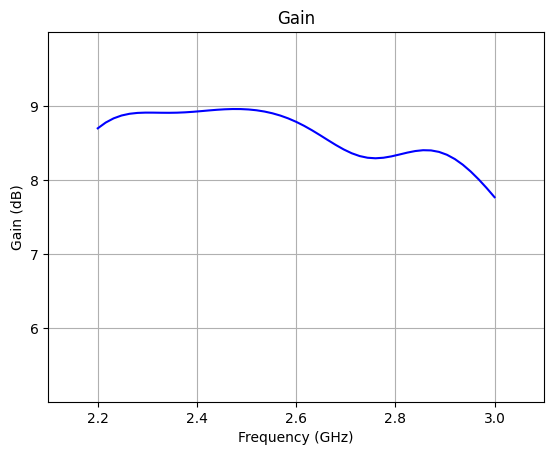

In [13]:
# Compute the right-handed circular polarization component
E_RH = (rad_field.Etheta - 1j*rad_field.Ephi)/(np.sqrt(2))
# Average power density [2]
W_RH = 0.5 * np.real(E_RH * np.conj(E_RH) / td.ETA_0)
# Compute the radiation intensity at the far field position [2]
Urad = r_proj**2 * W_RH
# Compute the directivity using the total power radiated [2]
P_radiated = sim_data["power"].flux.values
D = 4 * np.pi * Urad / (P_radiated)
# Now, compute the radiation efficiency of the antenna using the power delivered by the port to the antenna.
P_delivered = smatrix.TerminalComponentModeler.compute_power_delivered_by_port(port=coax_port, sim_data=sim_data)
rad_eff = P_radiated/P_delivered
# The gain of the antenna with respect to an isotropically radiating RHCP antenna [2]
gain = D*rad_eff

# Plot the gain at the position normal to the antenna as function of frequency
freq = D.f.values / 1e9
gain_zaxis = np.squeeze(D.sel(theta=0, phi=0).values)
y_tidy3D = 10 * np.log10(np.abs(gain_zaxis))
plt.plot(freq,y_tidy3D ,'-b')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Gain (dB)')
plt.title('Gain')
plt.xlim(2.1, 3.1)
plt.ylim(5, 10)
plt.yticks([6, 7, 8, 9])
plt.grid(True)
plt.show()

## References

[1] J. Wu, Y. Yin, Z. Wang and R. Lian, "Broadband Circularly Polarized Patch Antenna With Parasitic Strips," in *IEEE Antennas and Wireless Propagation Letters*, vol.   14, pp. 559-562, 2015.

[2] C. A. Balanis, *Antenna Theory: Analysis and Design*. John wiley & sons, 2016.